In [1]:
import sys
sys.path.append("../")

In [2]:
import pickle

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm

from simulator.simulator import Sim
from strategies.baselines import BestPosStrategy, StoikovStrategy
from utils.get_info import get_pnl, get_volumes
from utils.load_data import load_md_from_file


NROWS = 10_000_000

In [3]:
from utils.load_data import load_md_from_csv
md = load_md_from_csv("../data/books.csv", "../data/trades.csv", nrows=10_000_000)

latency = pd.Timedelta(10, 'ms').total_seconds()
md_latency = pd.Timedelta(10, 'ms').total_seconds()

In [4]:
sim = Sim(md[1_080_000:], latency, md_latency)
# sim = Sim(md[230_000:], latency, md_latency)

delay = pd.Timedelta(0.1, 's').total_seconds()
hold_time = pd.Timedelta(10, 's').total_seconds()
strategy = BestPosStrategy(delay, hold_time, trade_size=0.001)

In [5]:
%%time
trades_list_bp, md_list, updates_list, all_orders = strategy.run(sim)

CPU times: user 13 s, sys: 60.3 ms, total: 13.1 s
Wall time: 13.1 s


In [6]:
%%time
df_bp = get_pnl(updates_list, post_only=True)
df_bp['receive_ts'] = pd.to_datetime(df_bp['receive_ts'])

CPU times: user 38.5 s, sys: 77.9 ms, total: 38.6 s
Wall time: 38.6 s


In [7]:
%%time
df_bp_fee = get_pnl(updates_list, post_only=True, maker_fee=-0.00004, taker_fee=0.0004)
df_bp_fee['receive_ts'] = pd.to_datetime(df_bp_fee['receive_ts'])

CPU times: user 37.9 s, sys: 77.9 ms, total: 38 s
Wall time: 38 s


In [8]:
ask_made, bid_made, ask_take, bid_take = get_volumes(trades_list_bp)
ask_made, bid_made, ask_take, bid_take

(165.78900000042756,
 184.18900000051542,
 235.59400000076087,
 216.54500000066992)

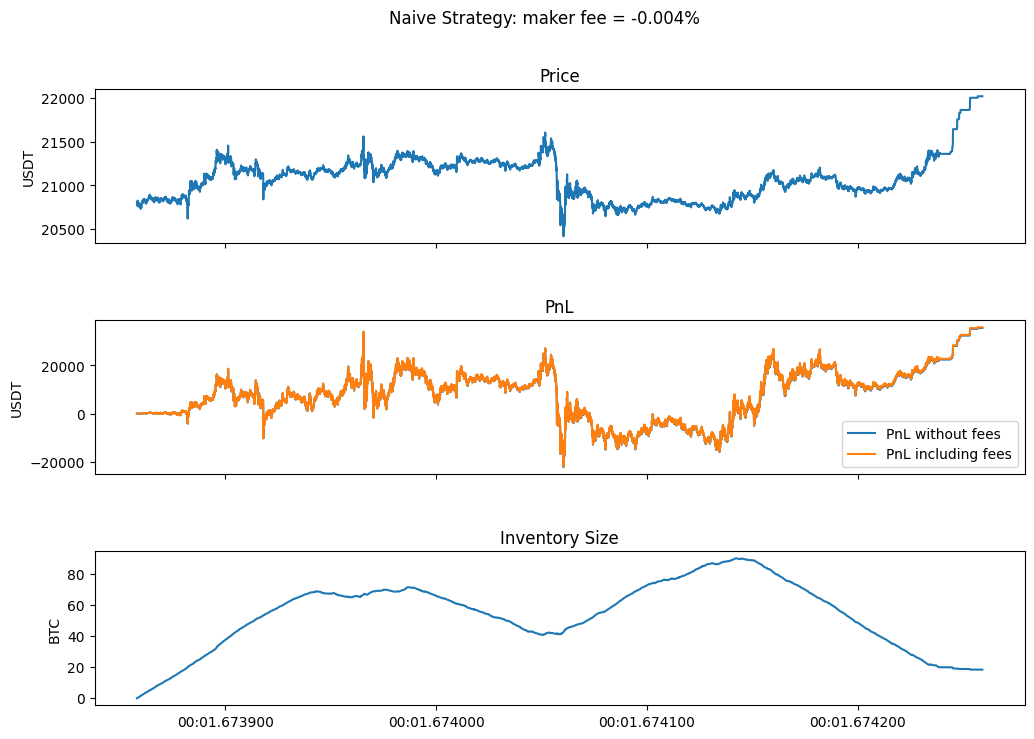

In [9]:
import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Naive Strategy: maker fee = -0.004%")

# 价格图
axes[0].plot(df_bp.iloc[::100, :]['receive_ts'], df_bp.iloc[::100, :]['mid_price'], label='Price')
axes[0].set_ylabel('USDT')
axes[0].set_title('Price')

# PnL 图
axes[1].plot(df_bp.iloc[::100, :]['receive_ts'], df_bp.iloc[::100, :]['total'], label='PnL without fees')
axes[1].plot(df_bp_fee.iloc[::100, :]['receive_ts'], df_bp_fee.iloc[::100, :]['total'], label='PnL including fees')
axes[1].set_ylabel('USDT')
axes[1].set_title('PnL')
axes[1].legend()

# 库存图
axes[2].plot(df_bp.iloc[::100, :]['receive_ts'], df_bp.iloc[::100, :]['BTC'], label='Inventory Size')
axes[2].set_ylabel('BTC')
axes[2].set_title('Inventory Size')

# 调整间距和布局
plt.subplots_adjust(hspace=0.5)

plt.show()

In [14]:
dfs_k = []

ks = [10, 12, 15]
# ks = [1, 10, 20]

for k in ks:
    sim = Sim(md[:230_000], latency, md_latency)

    delay = pd.Timedelta(0.1, 's').total_seconds()
    hold_time = pd.Timedelta(10, 's').total_seconds()
    terminal_date = pd.to_datetime('2023-01-22')

    strategy = StoikovStrategy(delay=delay, hold_time=hold_time, trade_size=0.01, risk_aversion=0.5, k=k,
                               post_only=True)

    trades_list_st, md_list, updates_list, all_orders = strategy.run(sim)

    df = get_pnl(updates_list, post_only=True, maker_fee=-0.00004, taker_fee=0.0004)
    df['receive_ts'] = pd.to_datetime(df['receive_ts'], unit='s')
    df.set_index('receive_ts', inplace=True)

    dfs_k.append(df)

In [20]:
dfs_k[2]

,exchange_ts,total,BTC,USD,mid_price
receive_ts,,,,,
2023-01-09 00:00:00.908999920,1.673222e+09,NaN,0.00,0.000000,NaN
2023-01-09 00:00:00.915999889,1.673222e+09,NaN,0.00,0.000000,NaN
2023-01-09 00:00:00.924999952,1.673222e+09,NaN,0.00,0.000000,NaN
2023-01-09 00:00:02.046000004,1.673222e+09,NaN,0.00,0.000000,NaN
2023-01-09 00:00:02.487999916,1.673222e+09,NaN,0.00,0.000000,NaN
...,...,...,...,...,...
2023-01-11 05:38:13.009999990,1.673415e+09,-1324.720134,-6.58,113276.178866,17416.55
2023-01-11 05:38:14.000000000,1.673415e+09,-1324.720134,-6.58,113276.178866,17416.55
2023-01-11 05:38:14.009999990,1.673415e+09,-1324.720134,-6.58,113276.178866,17416.55


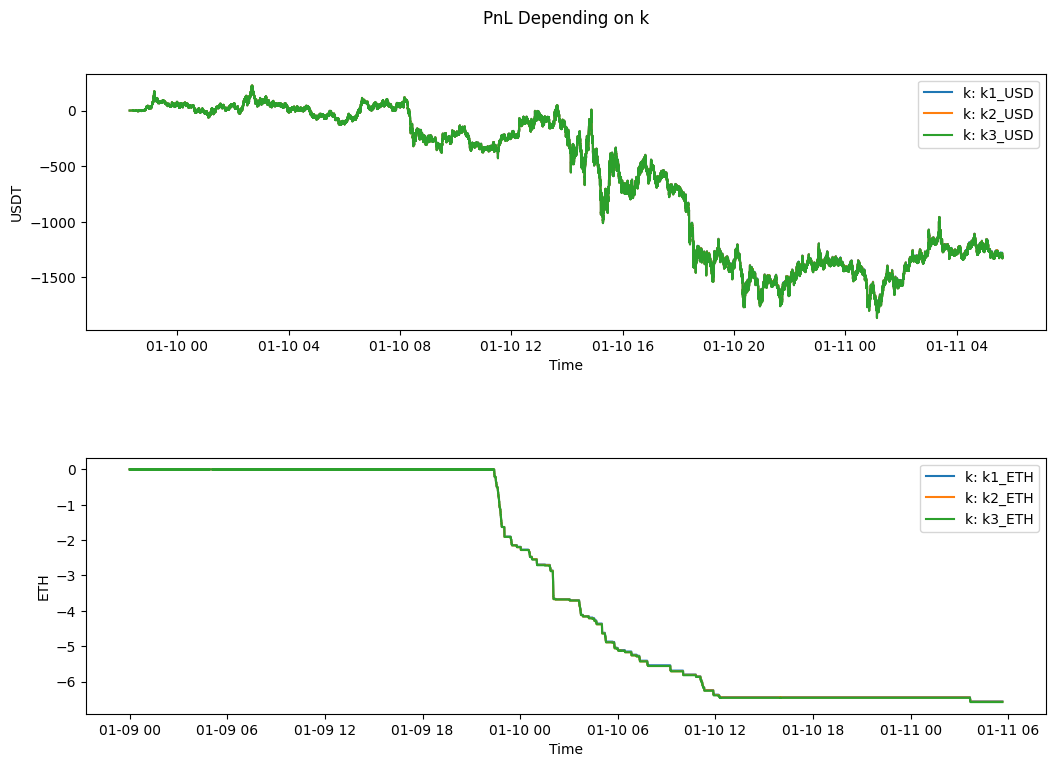

In [15]:
ks = ['k1', 'k2', 'k3'] # 对应 dfs_k 中的每个 DataFrame

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

for i, df_ in enumerate(dfs_k):
    df__ = df_[['total', 'BTC']].resample('1s').last().reset_index()
    ax1.plot(df__['receive_ts'], df__['total'], label=f'k: {ks[i]}_USD')
    ax2.plot(df__['receive_ts'], df__['BTC'], label=f'k: {ks[i]}_ETH')

# 设置图表标题和坐标轴标签
fig.suptitle("PnL Depending on k")
ax1.set_xlabel("Time")
ax1.set_ylabel("USDT")
ax2.set_xlabel("Time")
ax2.set_ylabel("ETH")

# 添加图例
ax1.legend()
ax2.legend()

# 调整布局, 以确保标题和坐标轴标签不重叠
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.5)

plt.show()


In [21]:
sim = Sim(md[1_080_002:], latency, md_latency)
delay = pd.Timedelta(0.1, 's').total_seconds()
hold_time = pd.Timedelta(10, 's').total_seconds()


strategy = StoikovStrategy(delay=delay, hold_time=hold_time, trade_size=0.001, risk_aversion=0.5, k=1.5,
                           post_only=True)

trades_list_st, md_list, updates_list, all_orders = strategy.run(sim)
df_st = get_pnl(updates_list, post_only=True, maker_fee=0, taker_fee=0)
df_st['receive_ts'] = pd.to_datetime(df_st['receive_ts'])

In [22]:
%%time
df_st_fee = get_pnl(updates_list, post_only=True, maker_fee=-0.00004, taker_fee=0.0004)
df_st_fee['receive_ts'] = pd.to_datetime(df_st_fee['receive_ts'])

CPU times: user 33.5 s, sys: 19.9 ms, total: 33.5 s
Wall time: 33.5 s


In [23]:
ask_made, bid_made, ask_take, bid_take = get_volumes(trades_list_st)
ask_made, bid_made, ask_take, bid_take

(16.091999999996684, 1.9429999999998968, 27.238000000010306, 58.94199999995333)

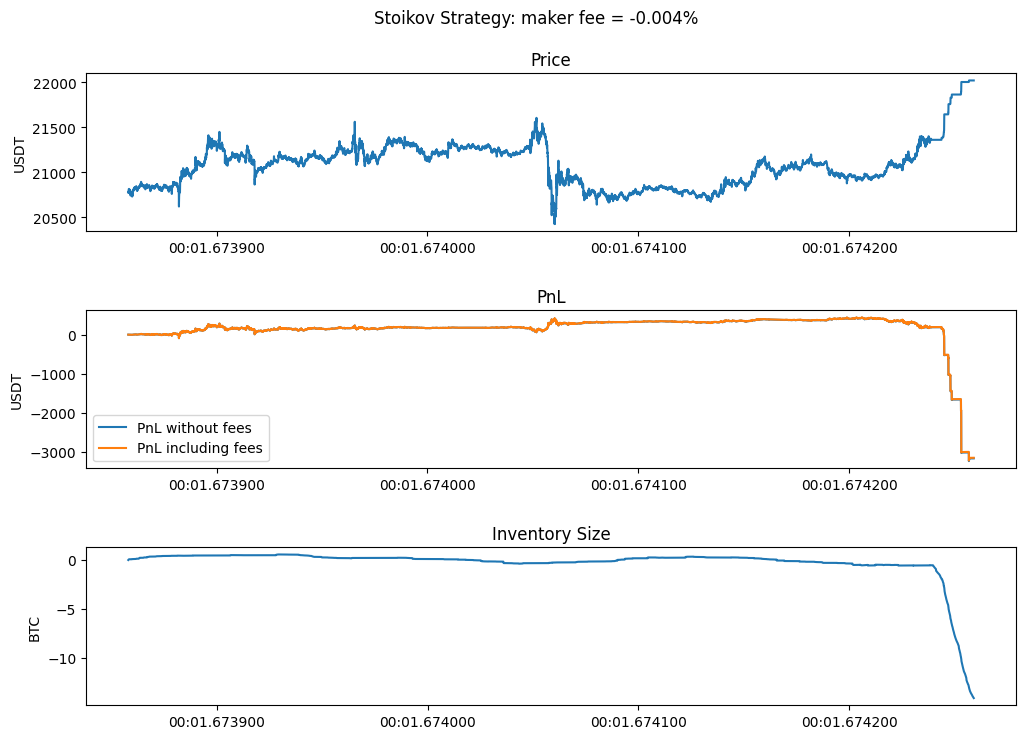

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
fig.suptitle("Stoikov Strategy: maker fee = -0.004%")

# 价格图
axes[0].plot(df_st.iloc[::100, :]['receive_ts'], df_st.iloc[::100, :]['mid_price'])
axes[0].set_title("Price")
axes[0].set_ylabel("USDT")

# PnL 图
axes[1].plot(df_st.iloc[::100, :]['receive_ts'], df_st.iloc[::100, :]['total'], label="PnL without fees")
axes[1].plot(df_st_fee.iloc[::100, :]['receive_ts'], df_st_fee.iloc[::100, :]['total'], label="PnL including fees")
axes[1].set_title("PnL")
axes[1].set_ylabel("USDT")
axes[1].legend()

# 库存规模图
axes[2].plot(df_st.iloc[::100, :]['receive_ts'], df_st.iloc[::100, :]['BTC'])
axes[2].set_title("Inventory Size")
axes[2].set_ylabel("BTC")

# 调整布局
plt.subplots_adjust(top=0.9, hspace=0.5)

# 显示图形
plt.show()

In [25]:
import torch

from strategies.rl import A2CNetwork, Policy, RLStrategy, ComputeValueTargets

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [26]:
with open('../data/features.pickle', 'rb') as f:
    ess_dict = pickle.load(f)

ess_df = pd.DataFrame.from_dict(ess_dict, orient='index').reset_index().rename(columns={'index': 'receive_ts'})

del(ess_dict)

In [29]:
means = np.zeros(57)
stds = np.zeros(57)
means[:] = 1
stds[:] = 1

In [30]:
model = A2CNetwork(n_actions=10, DEVICE=DEVICE).to(DEVICE)
model.load_state_dict(torch.load("../models/btc_50step_15_50act_rew_pen.pth"))
model.eval()

policy = Policy(model)

delay = pd.Timedelta(0.1, 's').total_seconds()
hold_time = pd.Timedelta(10, 's').total_seconds()
strategy = RLStrategy(policy, ess_df, 1.0,
                      means, stds, delay, hold_time, [ComputeValueTargets(policy)],
                      trade_size=0.01, post_only=True, taker_fee=0.0004, maker_fee=-0.00004)

In [31]:
strategy.reset()
sim = Sim(md[1_080_002:],
          execution_latency=pd.Timedelta(10, 'ms').total_seconds(),
          md_latency=pd.Timedelta(10, 'ms').total_seconds())
with torch.no_grad():
    trades_list, md_list, updates_list, actions_history, trajectory = strategy.run(sim, mode='test')

/home/qiangxu/Projects/market-making/adhoc/../strategies/rl.py:198: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.features_df.loc[
/home/qiangxu/Projects/market-making/adhoc/../strategies/rl.py:198: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.059642800000062834' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.features_df.loc[


In [ ]:
%%time

df_rl = get_pnl(updates_list, post_only=True, maker_fee=0, taker_fee=0)
df_rl['receive_ts'] = pd.to_datetime(df_rl['receive_ts'])

In [ ]:
%%time

df_rl_fee = get_pnl(updates_list, post_only=True, maker_fee=-0.00004, taker_fee=0.0004)
df_rl_fee['receive_ts'] = pd.to_datetime(df_rl_fee['receive_ts'])

In [ ]:
ask_made, bid_made, ask_take, bid_take = get_volumes(trades_list)
ask_made, bid_made, ask_take, bid_take